# Spin-orbit coupling in Bose-Einstein Condensates

In this example we want to simulate a spin-orbit coupled Bose-Einstein condensate (BEC) in 1D. Spin-orbit coupling is induced via two Raman transitions. For this problem the `SumBasis` of *QuantumOptics.jl* allows us to easily construct the Hamiltonian and calculate its groundstate via exact diagonalization or imaginary time evolution using the "Lazy" formulation (i.e. split step method).

We consider a two-component BEC of atoms with two hyperfine states, which we call "pseudospin" $\left|\uparrow\right>$ and $\left|\downarrow\right>$. These two states are coupled via a Raman process induced by two counterpropagating laser beams with pump strength $\Omega_R$. This configuration gives rise to a typical spin-1/2 configuration which can be represented by the single particle spinor Hamiltonian (for details see for example "Pitaevskii, Lev, and Sandro Stringari, *Bose-Einstein condensation and superfluidity*, Vol. 164, Oxford University Press, 2016."). The Hamiltonian in matrix form reads

$h=
%
\begin{pmatrix}
\frac{\hat{p}^2}{2m} + \frac{\hbar\delta}{2} 
%
& \hbar \Omega_R e^{i 2 k y} \\
%
\hbar \Omega_R e^{-i 2 k y} 
%
& \frac{\hat{p}^2}{2m} - \frac{\hbar\delta}{2}
\end{pmatrix}$, $\quad \quad$ (1)

$\hat{p}=-i\hbar\partial_x$ is the canonical momentum operator and $k=2\pi/\lambda$ is the wave number of the two Raman beams. The energy difference between the two hyperfine states is called $\delta$ and it acts as an effective magnetic field.

By performing a simple unitary transformation, this Hamiltonian can be transformed into the typical spin-orbit coupling form

$h_{SOC}=\frac{(p-\hbar k\sigma_z)^2}{2}+\frac{\hbar\Omega_R}{2}\sigma_x+\frac{\hbar\delta}{2}\sigma_z$,$\quad \quad$ (2)

where $\sigma_{x,z}$ are the usual $2 \times 2$ Pauli matrices.

This Hamiltonian exhibits the typical spin-orbit nature, i.e., different spin components couple to different momenta, by equal contributions of Rashba and Dresselhaus couplings. Hence, the employed Raman transitions give rise to spin-orbit coupling like it is found in solid state materials where for example the linear crystal momentum interacts with the spin of an electron.

The spin-orbit coupling Hamiltonian also has another important feature. The canonical momentum $p=-i \hbar \partial_x$ does no longer coincide with the physical momentum of the spin-up and spin-down components. The physical momentum for a spin-up or spin-down particle is given as 


$\mathcal{P}_\uparrow=p+\hbar k$ and $\mathcal{P}_\downarrow=p-\hbar k$. $\quad \quad$ (3)

This also implies that $h_{SOC}$ breaks time reversal and parity symmtery along the $x$-direction. In addition, Galilean invariance is broken. The relation (3) will be used later when comparing the numerical results with the analytics.

The many-body Hamiltonian in second quantization for bosonic particles occupying a one-dimensional space of length $L$ is given via (for the moment we omit the two-body interactions, they will be added later)

$H=\int_L \underline{\Psi}(x)^\dagger h \underline{\Psi}(x)\, \mathrm{d}x$,

where we introduced the spinor $\underline{\Psi}(x)=\left(\hat{\Psi}_\uparrow(x),\hat{\Psi}_\downarrow(x)\right)^T$ consisting of the single component field operators $\hat{\Psi}_{\uparrow/\downarrow}(x)$

Let us find the ground states for this system in the mean-field limit.

In [2]:
using QuantumOptics
using OrdinaryDiffEq, DiffEqCallbacks
using PyPlot

#use latex fonts for axis labelling
rc("text",usetex=true)
rc("font", family="serif")

## Non-interacting case

In this first part we want to find the ground state of the Hamiltonian without taking two-body interactions into account. This can be done by diagonalizing the spinor Hamiltonian.

First we define the size of the space and fix the the relevant physical parameters. Note that due to the spin orbit coupling nature of the Hamiltonian it is not sufficient to restrict the treatment to a single unit cell with periodic boundary conditions. The total size of the position basis sets the resolution in momentum space via $\Delta p =  \hbar 2\pi/L$ where $L$ is the total length of the position space. Due to the fact that spin-orbit coupling populates momenta which are not just multiples of $\hbar k$, the resolution of the momentum space must be very good. We restrict ourselves to $N=100$ unitcells in this example, however, this number can be increased even further.

In [3]:
# define x-space
Nunitcells = 100 #number of unit cells

UC = 1/2
Lx = UC * Nunitcells
x_min = 0
x_max = Lx
x_steps_UC = 4 # steps for one unit cell
const x_steps = x_steps_UC * Nunitcells
dx = (x_max - x_min)/x_steps

# external parameters
ΩR = 3. # pump strength
δ = 1e-10 # energy difference between hyperfine states
k = 2*π; # Raman beam wavevector

Next we specify the position and momentum bases and from this construct the position and momentum operators. Note that the wavefunctions of both spin components are defined on this space.

In [4]:
# Basis creation
b_x = PositionBasis(x_min, x_max, x_steps)
xx = samplepoints(b_x)

b_p = MomentumBasis(b_x)
pp = samplepoints(b_p)

# position and momentum operators
x = position(b_x)
p = momentum(b_x);

Now we generate the Hamiltonian. For this we first define the Hamiltonians for each spin component independently in the basis defined above.

The spinor Hamiltonian is then constructed as follows: The blocks along the main diagonal in Eq. (1) (kinetic Hamiltonian and Hamiltonian $\propto \delta$) can be correctly assigned by using the direct sum $\oplus$ (or `directsum`) of the two single spin Hamiltonians. The off-diagonal blocks are assigned via the `setblock!` function.

In [5]:
# define single spin Hamiltonians
Hkin = p^2/k^2 # units of ωᵣ

Ω_R_fun(x) = ΩR/2 * exp.(1im * 2 * k * x)

Ω_R = potentialoperator(b_x,Ω_R_fun)

H_up = Hkin + δ/2 * one(b_x)
H_down = Hkin - δ/2 * one(b_x)

# build Hamiltonian in spinor basis
H = H_up ⊕ H_down #diagonal blocks

# assign off-diagonals
setblock!(H,Ω_R,1,2) # off-diagonal block (1,2)
setblock!(H,dagger(Ω_R),2,1) # off-diagonal block (2,1)

H = (dagger(H) + H)/2; # make Hamiltonian hermitian

To find the groundstate of this spinor Hamiltonian we can now use the eigenstates function.

In order to get the space dependent states for the two spin components separately again, we have to extract these states from the spinor after finding the ground state.

Since it is most instructive to analyze the momentum state distribution for this system as we will see later, we also calculate these quanities for the two groundstate wavefunctions by using the `transform` function.

In [6]:
# calculate groundstate
e_gs, ψ_spinor_gs = eigenstates(H,1)

# extract spin states (spin up --> first half of spinor, spin down --> second half of spinor)
ψ_up_gs = getblock(ψ_spinor_gs[1],1)
ψ_down_gs = getblock(ψ_spinor_gs[1],2)

# calculate momentum space representation of the groundstates
Tpx = transform(b_p, b_x)
Txp = dagger(Tpx)
ψ_up_gs_mom = Tpx * ψ_up_gs
ψ_down_gs_mom = Tpx * ψ_down_gs;

Now we use *matplotlib* via `PyPlot` to plot the momentum space distribution of the two spin states and the corresponding density distribution in real space.

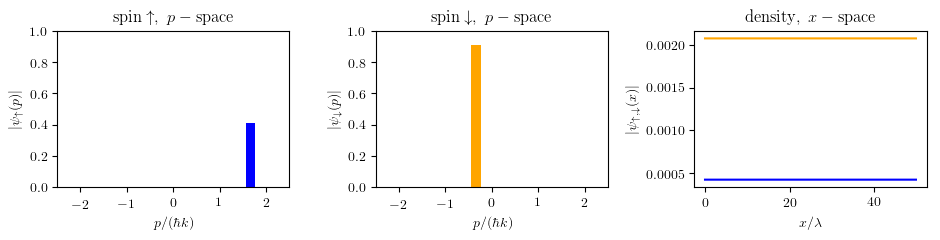

In [7]:
figure(figsize = (9.5,2.5), dpi = 100, facecolor = "w", edgecolor = "k")
subplot(1,3,1)
bar(pp./k,abs.(ψ_up_gs_mom.data),width = 0.2,color = "blue")
title(L"\mathrm{spin}\uparrow, \, \, p-\mathrm{space}")
xlabel(L"p/(\hbar k)")
ylabel(L"|\psi_\uparrow(p)|")
xlim(-2.5,2.5)
ylim(0,1)
subplot(1,3,2)
bar(pp./k,abs.(ψ_down_gs_mom.data),width=0.2,color="orange")
ylim(0,1)
title(L"\mathrm{spin}\downarrow, \, \, p-\mathrm{space}")
xlabel(L"p/(\hbar k)")
ylabel(L"|\psi_\downarrow(p)|")
xlim(-2.5,2.5)
subplot(1,3,3)
plot(xx,abs2.(ψ_up_gs.data),color="blue")
plot(xx,abs2.(ψ_down_gs.data),color="orange")
title(L"\mathrm{density},\,  \, x - \mathrm{space}")
xlabel(L"x/\lambda")
ylabel(L"|\psi_{\uparrow,\downarrow}(x)|")
tight_layout()

We see that in the non-interacting case only one momentum is populated for each spinor component. In addition, the two spin states are not populated equally (if $\Omega_R<4\omega_\mathrm{rec}$). We also see that the momentum which is occupied is not necessarily a multiple of $\hbar k$ as it was already pointed out above. Note that the momenta we get are physical (!) momenta. To get the corresponding canonical momenta we need to shift the physical momentum obtained above by $\pm \hbar k$ (with $+$ for the spin-$\downarrow$ component and $-$ for the spin-$\uparrow$ component) as we can see from Eq. (3).

The canonical momenta which are occupied for a given pump strength can be calculated analytically from (2):

$p_{\uparrow,\downarrow} = \hbar k\sqrt{1-\left(\frac{\hbar \Omega_R}{4 E_\mathrm{rec}}\right)^2}$ $\quad$ $\mathrm{for}$ $\quad$ $\Omega_R < 4\omega_\mathrm{rec}$, $\quad$ (4)

where $E_\mathrm{rec}=\frac{\hbar^2 k^2}{2m}=\hbar\omega_\mathrm{rec}$ is the recoil energy imposed by scattering a Raman photon. Let's compare our numerical results with this analytical formula.

For this we have to loop over a list of different pump strengths $\Omega_R$, find the groundstate and save the occupied momentum for each $\Omega_R$. To get the canonical momentum we also need to shift the physical momenta correspondingly.

In [8]:
# scan list
NΩR = 40
ΩRmin = 0.0
ΩRmax = 5.0
ΩR_l = [ΩRmin:(ΩRmax-ΩRmin)/(NΩR-1):ΩRmax;]

p_can_occ_up_l = []
p_can_occ_down_l = []

# build Hamiltonian in spinor basis
Hkin = p^2/k^2
H_up = Hkin + δ * one(b_x)
H_down = Hkin
H = H_up ⊕ H_down # diagonal blocks

for q in 1:NΩR
    ΩR_scan = ΩR_l[q]
    Ω_R_fun(x) = ΩR_scan/2 * exp.(1im * 2 * k * x)
    Ω_R = potentialoperator(b_x,Ω_R_fun)

    setblock!(H,Ω_R,1,2) # off-diagonal block (1,2)
    setblock!(H,dagger(Ω_R),2,1) # off-diagonal block (2,1)
    
    H = (dagger(H) + H)/2; # make Hamiltonian hermitian

    # calculate groundstate
    e_gs, ψ_spinor_gs = eigenstates(H,1)

    # extract spin states
    ψ_up_gs = getblock(ψ_spinor_gs[1],1)
    ψ_down_gs = getblock(ψ_spinor_gs[1],2)
    
    # transform to momentum space
    ψ_up_gs_mom = Tpx * ψ_up_gs
    ψ_down_gs_mom = Tpx * ψ_down_gs;

    p_can_occ_up = pp[argmax(abs.(ψ_up_gs_mom.data))]./k.-1 # shift -1ħk to get canonical momentum
    p_can_occ_down = pp[argmax(abs.(ψ_down_gs_mom.data))]./k.+1 # shift +1ħk to get canonical momentum

    push!(p_can_occ_up_l,p_can_occ_up)
    push!(p_can_occ_down_l,p_can_occ_down)
end

Now we can compare the numerically obtained results with the analytical formula in Eq. (4).

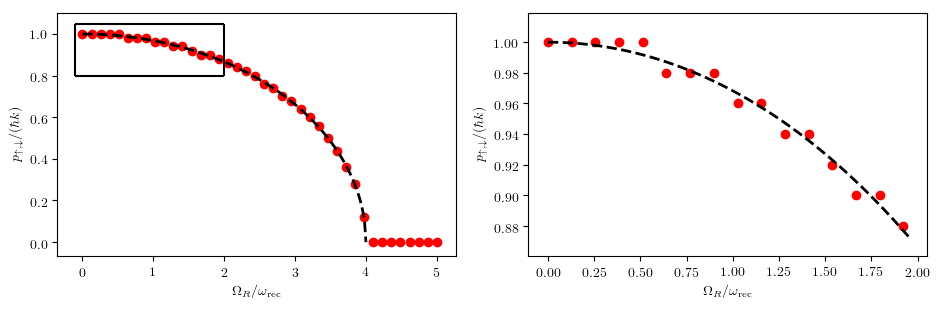

In [13]:
# define ΩR range for analytic plot
NΩR_an = 200
ΩRmin_an = 0
ΩRmax_an = 4.0
ΩR_l_an = [ΩRmin_an:(ΩRmax_an-ΩRmin_an)/(NΩR_an-1):ΩRmax_an;]

p_can_analytic=k*sqrt.(1.0.-(ΩR_l_an/4).^2)./k #analytic formula (in correct units)

figure(figsize = (9.5,3.2))
subplot(121)
scatter(ΩR_l,p_can_occ_down_l,color="red") #numerical
plot(ΩR_l_an,p_can_analytic,"--",linewidth=2,color="black") #analytical
#ylim(0,1.05)
xlabel(L"$\Omega_R/\omega_\mathrm{rec}$")
ylabel(L"$p_{\uparrow,\downarrow}/(\hbar k)$")
hlines(1.05,-.1,2)
hlines(0.8,-.1,2)
vlines(-0.1,0.8,1.05)
vlines(2,0.8,1.05)
subplot(122)
scatter(ΩR_l[1:16],p_can_occ_down_l[1:16],color="red") #numerical
plot(ΩR_l_an[1:98],p_can_analytic[1:98],"--",linewidth=2,color="black") #analytical
xlabel(L"$\Omega_R/\omega_\mathrm{rec}$")
ylabel(L"$p_{\uparrow,\downarrow}/(\hbar k)$")
tight_layout()

We find very good agreement between the numerical results (red dots) and the analytical expression (black dashed). The small deviations at $\Omega_R=4\omega_\mathrm{rec}$ and the "staircase" behaviour one can observe in the momentum (magnified on the right side) is due to the chosen number of unitcells ($N=100$) resulting in a too small momentum space resolution to resolve the small differenerences between these momenta. If we would increase the number of unit cells even further the results would coincide even better with the analytics.

## Including two-body interactions (stripe phase)

Including two-body interactions adds another feature to this system. In this case the system can enter the so-called "stripe phase" if $\Omega_R<4\omega_\mathrm{rec}$ and $\delta=0$. The stripe phase is a periodic density modulation which spontaneously breaks the contiunuous symmetry of the Hamiltonian and, therefore, has supersolid properties. Let's see if we can reproduce this result. In this case the diagonalization of the Hamiltonian it is no longer sufficient, since two-body interactions can only be taken into account by including a non-linear interaction term in the equations of motion. This leads to two coupled Gross-Pitaevski equations

$i \hbar \partial_t \psi_\uparrow (x,t) = \left(-\frac{\hbar^2}{2m} \nabla^2 + g |\psi_\uparrow (x,t)|^2 + g_{\uparrow\downarrow}|\psi_\downarrow (x,t)|^2\right) \psi_\uparrow (x,t) + \frac{\hbar \Omega_R}{2}\psi_\downarrow(x,t)$

$i \hbar \partial_t \psi_\downarrow (x,t) = \left(-\frac{\hbar^2}{2m} \nabla^2 + g |\psi_\downarrow (x,t)|^2 + g_{\uparrow\downarrow}|\psi_\uparrow (x,t)|^2\right) \psi_\downarrow (x,t) + \frac{\hbar \Omega_R}{2}\psi_\uparrow(x,t)$

We already assumed $g_{\uparrow\uparrow}=g_{\downarrow\downarrow}\equiv g$ and $g_{\uparrow\downarrow}$. To reduce the number of parameters we define the dimensionless quantitiy $\gamma=\frac{g-g_{\downarrow\downarrow}}{g+g_{\downarrow\downarrow}}$, which scales the ratio between intra-species and cross-species interactions.

First we define all the relavant parameters for the calculation.

In [14]:
#interaction strength
γ = 0.8
g = 10.0
g_uu = g
g_dd = g

g_du = g * (1 - γ)/(1 + γ)
g_ud = g_du;

To calculate the ground state of the coupled Gross-Piatevski equations we use the imaginary time evolution method. This method is most efficient if one uses a split-step solver, i.e., calculate the kinetic energy part of the time evolution in momentum space where $H_\mathrm{kin}=p^2/(2m)$ is diagonal and the rest of the evolution in real-space.

In *QuantumOptics.jl* this is done via the "Lazy" formulation. This formulation can also be used in the spinor basis if one defines new transformation operators between real and momentum space via the `directsum` ($\oplus$) of the two transformation operators defined for the single spin components.

In [15]:
Txp = transform(b_x, b_p; ket_only=true)
Tpx = transform(b_p, b_x; ket_only=true)
Txp_tot = Txp ⊕ Txp
Tpx_tot = Tpx ⊕ Tpx;

Since the imaginary time evolution does not conserve the norm of the state, we have to renormalize the state after every timestep. This can easily be done via a renormalization callback in *DifferentialEquations*.

In [16]:
# renormalization callback
norm_func(u, t, integrator) = normalize!(u)
ncb = FunctionCallingCallback(norm_func; func_everystep = true, func_start = false);

Now we can calculate the time evolution of the coupled GPE equations. As an initial state we use the groundstate for the non-interacting case calculated above.

We already introduced the operators for transforming from momentum space to real space. To use the advantage of a split step integration we need to sum the different parts of the Hamiltonian using a `LazySum`. To demonstrate the contiunous symmetry breaking, which is expected to occur we include a random phase $\phi$ to the two counterpropagating Raman beams. This phase can take any value out of $[0,2\pi]$ due to the continuous symmetry of the Hamiltonian.

In [17]:
# kinetc energy  in momentum space
p_p = momentum(b_p)
Hkin_p = p_p^2/k^2
Hkin_tot = Hkin_p ⊕ Hkin_p

H_up = δ/2 * one(b_x)
H_down = -δ/2 * one(b_x)
H1 = H_up ⊕ H_down

# Off-diagonal blocks
ϕ = rand([0:0.01:2π;]) #random phase --> spontaneous symmetry breaking 
Ω_R_fun_int(x) = ΩR/2 * exp.(1im * 2 * k * x) * exp(1im * ϕ)
Ω_R_int = potentialoperator(b_x,Ω_R_fun_int)

setblock!(H1,Ω_R_int,1,2) #off-diagonal block (1,2)
setblock!(H1,dagger(Ω_R_int),2,1) #off-diagonal block (2,1)

# for state dependent non-linear interactions
Hψ_up = one(b_x)
Hψ_down = one(b_x)
Hψ = Hψ_up ⊕ Hψ_down

# Total Hamiltonian as lazy sum
H_tot = -1im * LazySum(H1, LazyProduct(Txp_tot, Hkin_tot, Tpx_tot), Hψ) # --> for imaginary time evolution

ψ0 = ψ_up_gs ⊕ ψ_down_gs #initial state

# integrator tolerances
abstol_int = 1e-4
reltol_int = 1e-4
maxiters_int = 1e8

# integration time settings
t0 = 0
tend = 20000
dt = 10000;

T = [t0:dt:tend;]

function H_im(t, ψ) # Update state-dependent term in H
    Hψ.data.nzval[1:x_steps] .= g_uu/dx * abs2.(getblock(ψ,1).data) + g_ud/dx * abs2.(getblock(ψ,2).data)
    Hψ.data.nzval[x_steps+1:end] .= g_dd/dx * abs2.(getblock(ψ,2).data) + g_du/dx * abs2.(getblock(ψ,1).data)
    return H_tot
end

tout, ψ_it = timeevolution.schroedinger_dynamic(T, ψ0, H_im, callback=ncb, abstol=abstol_int, reltol=reltol_int, maxiters=maxiters_int)

ψ_spinor_gs_int = ψ_it[end];

To visualize the state, we again extract the single spin wavefunctions and transform them into momentum space.

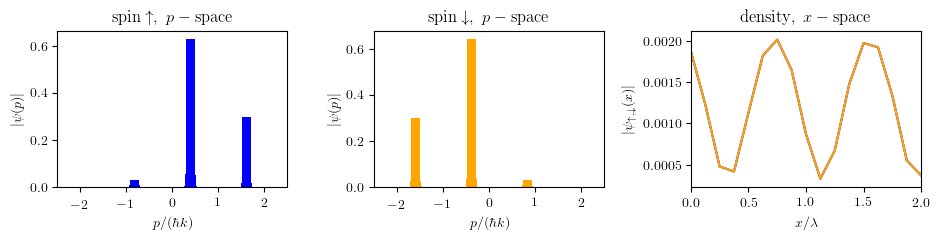

In [18]:
# extract state-Kets for 2 components
ψ_up_int = getblock(ψ_spinor_gs_int,1)
ψ_down_int = getblock(ψ_spinor_gs_int,2)

# calculate momentum space distribution
ψ_up_int_mom = Tpx * ψ_up_int
ψ_down_int_mom = Tpx * ψ_down_int

figure(figsize = (9.5,2.5), dpi=100, facecolor="w", edgecolor="k")
subplot(1,3,1)
bar(pp./k,abs.(ψ_up_int_mom.data),width=0.2,color="blue")
xlim(-2.5,2.5)
title(L"\mathrm{spin}\uparrow, \, \, p-\mathrm{space}")
xlabel(L"p/(\hbar k)")
ylabel(L"|\psi(p)|")
subplot(1,3,2)
bar(pp./k,abs.(ψ_down_int_mom.data),width=0.2,color="orange")
xlim(-2.5,2.5)
title(L"\mathrm{spin}\downarrow, \, \, p-\mathrm{space}")
xlabel(L"p/(\hbar k)")
ylabel(L"|\psi(p)|")
subplot(1,3,3)
plot(xx,abs2.(ψ_up_int.data),color="blue")
plot(xx,abs2.(ψ_up_int.data),color="orange")
title(L"\mathrm{density},\,  \, x - \mathrm{space}")
xlabel(L"x/\lambda")
ylabel(L"|\psi_{\uparrow,\downarrow}(x)|")
xlim(0,2)
tight_layout()

We see that in contrast to the non-interacting case both spin components exhibit a spatially periodic denstiy distribution and they are populated equally. This phase is called the "stripe phase" of a spin-orbit coupled BEC. In this phase the continuous symmetry of the Hamiltonian is spontaneously broken. This can be seen by running the simulation above several times. The position of the maxima of the density distribution for the two spin components are shifted randomly in space. Hence, the stripe phase of a spin-orbit coupled BEC fulfills all criteria to be called a "supersolid" (coherent BEC with an additionally broken continuous symmetry).

Note that for weak interaction strengths $g$ the stripe phase only occurs for small values of $\Omega_R$. In general, the stripe phase can only be realized as long as $\Omega_R<4\omega_\mathrm{rec}$.